Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## MNIST Feed-Forward Neural Network

In [1]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
from torch.autograd import Variable 
from torch.utils import data

In [5]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


## Initilaize Data Loader

In [13]:
def MNIST_DATA(root='./',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(),
                                    download=True)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download=True)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the better. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [15]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 

[+] Get the MNIST DATA


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
[+] Finished loading data & Preprocessing


/Users/kwonsoonjae/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Define Trainer

In [26]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs#.cuda()
                labels = labels#.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Question 1) what if we dind't clear up the gradients?

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() # Question 2) Why should we change the network into eval-mode?
    
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs#.cuda()
            labels = labels#.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))

## Let's create Model by yourself

![activation](./imgs/activation.png)

### Exp (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [27]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = F.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [28]:
mnist_net = MNIST_Net()#.cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [29]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [30]:
trainer.train(epoch = 4)

/Users/kwonsoonjae/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   500] loss: 2.327
[1,  1000] loss: 2.297
[1,  1500] loss: 2.277
[2,   500] loss: 2.253
[2,  1000] loss: 2.242
[2,  1500] loss: 2.230
[3,   500] loss: 2.208
[3,  1000] loss: 2.194
[3,  1500] loss: 2.182
[4,   500] loss: 2.155
[4,  1000] loss: 2.138
[4,  1500] loss: 2.121
Finished Training


In [31]:
trainer.test()


Test set:  Accuracy: 5921/10000 (59%)



### Exp (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [32]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [33]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [34]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [35]:
trainer.train(epoch = 4)

[1,   500] loss: 2.281
[1,  1000] loss: 2.219
[1,  1500] loss: 2.141
[2,   500] loss: 1.952
[2,  1000] loss: 1.821
[2,  1500] loss: 1.672
[3,   500] loss: 1.403
[3,  1000] loss: 1.260
[3,  1500] loss: 1.141
[4,   500] loss: 0.973
[4,  1000] loss: 0.905
[4,  1500] loss: 0.848
Finished Training


In [36]:
trainer.test()


Test set:  Accuracy: 8336/10000 (83%)



#### Question 3) Is there any difference in performance according to the activiation function?

ReLU가 Sigmoid에 비해 압도적으로 성능이 좋음!

### Exp (3) 3-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [37]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [38]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

In [39]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [40]:
trainer.train(epoch = 4)

[1,   500] loss: 2.309
[1,  1000] loss: 2.304
[1,  1500] loss: 2.302
[2,   500] loss: 2.301
[2,  1000] loss: 2.300
[2,  1500] loss: 2.299
[3,   500] loss: 2.299
[3,  1000] loss: 2.299
[3,  1500] loss: 2.298
[4,   500] loss: 2.299
[4,  1000] loss: 2.297
[4,  1500] loss: 2.298
Finished Training


In [41]:
trainer.test()


Test set:  Accuracy: 1135/10000 (11%)



### Exp (4) 3-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [42]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [43]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

In [44]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [45]:
trainer.train(epoch = 4)

[1,   500] loss: 2.303
[1,  1000] loss: 2.286
[1,  1500] loss: 2.269
[2,   500] loss: 2.226
[2,  1000] loss: 2.190
[2,  1500] loss: 2.144
[3,   500] loss: 2.026
[3,  1000] loss: 1.938
[3,  1500] loss: 1.826
[4,   500] loss: 1.602
[4,  1000] loss: 1.463
[4,  1500] loss: 1.325
Finished Training


In [46]:
trainer.test()


Test set:  Accuracy: 7339/10000 (73%)



#### Question 4) Is training gets done easily in experiment (3),(4) compared to experiment (1),(2)? If it doesn't, why not?

- (3), (4)가 (1), (2)에 비해 시간도 더 오래 걸리고 성능도 더 안좋게 나옴
- 이유는 일단 parameter가 더 많아서 연산 시간이 오래 걸리며, 성능은 잘 모르겠음 아직

#### Question 5) What would happen if there is no activation function?
- 선형 결합으로만 이루어지기 때문에 문제 발생 -> 어떤 문제인지는 좀더 찾아보자

## Let's Change our Optimizer

![Adam](./imgs/adam.jpeg)

Reference: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

### Exp (5) 3-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [47]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [48]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [49]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [50]:
trainer.train(epoch = 4)

[1,   500] loss: 0.650
[1,  1000] loss: 0.313
[1,  1500] loss: 0.252
[2,   500] loss: 0.196
[2,  1000] loss: 0.185
[2,  1500] loss: 0.166
[3,   500] loss: 0.134
[3,  1000] loss: 0.136
[3,  1500] loss: 0.132
[4,   500] loss: 0.102
[4,  1000] loss: 0.111
[4,  1500] loss: 0.105
Finished Training


In [51]:
trainer.test()


Test set:  Accuracy: 9660/10000 (97%)



### Exp (6) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [52]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [53]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [54]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [55]:
trainer.train(epoch = 4)

[1,   500] loss: 0.680
[1,  1000] loss: 0.311
[1,  1500] loss: 0.289
[2,   500] loss: 0.226
[2,  1000] loss: 0.209
[2,  1500] loss: 0.209
[3,   500] loss: 0.175
[3,  1000] loss: 0.167
[3,  1500] loss: 0.156
[4,   500] loss: 0.130
[4,  1000] loss: 0.135
[4,  1500] loss: 0.145
Finished Training


In [56]:
trainer.test()


Test set:  Accuracy: 9596/10000 (96%)



## Batch-Normalization

![normalization](./imgs/normalization.png)

Reference: Andrew Ng, Deep Learning

### Exp (7) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [57]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [58]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [59]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [60]:
trainer.train(epoch = 4)

[1,   500] loss: 0.713
[1,  1000] loss: 0.346
[1,  1500] loss: 0.282
[2,   500] loss: 0.225
[2,  1000] loss: 0.209
[2,  1500] loss: 0.204
[3,   500] loss: 0.168
[3,  1000] loss: 0.171
[3,  1500] loss: 0.164
[4,   500] loss: 0.150
[4,  1000] loss: 0.147
[4,  1500] loss: 0.141
Finished Training


In [61]:
trainer.test()


Test set:  Accuracy: 9628/10000 (96%)



### Exp (8) 3-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [62]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.bn0 = nn.BatchNorm1d(50) # BatchNorm 1 
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) # BatchNorm 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [63]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [64]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [65]:
trainer.train(epoch = 4)

[1,   500] loss: 0.639
[1,  1000] loss: 0.259
[1,  1500] loss: 0.215
[2,   500] loss: 0.150
[2,  1000] loss: 0.143
[2,  1500] loss: 0.140
[3,   500] loss: 0.111
[3,  1000] loss: 0.122
[3,  1500] loss: 0.119
[4,   500] loss: 0.088
[4,  1000] loss: 0.102
[4,  1500] loss: 0.100
Finished Training


In [66]:
trainer.test()


Test set:  Accuracy: 9753/10000 (98%)



#### Question 6) Is there any performance difference before/after applying the batch-norm?
- Batch-norm 하니까 test accuracy가 1% 가량 더 좋아짐!

## HW 1.1 Let's Do It: Let's achieve performance greater than 97%!

In [198]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28, 60) # Layer 1
        self.bn0 = nn.BatchNorm1d(60) # BatchNorm 1 
        self.fc1 = nn.Linear(60, 40) # Layer 2
        self.bn1 = nn.BatchNorm1d(40) # BatchNorm 2
        self.fc2 = nn.Linear(40, 20) # Layer 3
        self.bn2 = nn.BatchNorm1d(20) # BatchNorm 3
        self.fc3 = nn.Linear(20, 10) # Layer 4
        self.dropout = nn.Dropout(0.1)
        self.xavier_init()

    def forward(self, x):
        
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x
    
    def xavier_init(self):
        nn.init.xavier_normal_(self.fc0.weight)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)


In [203]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [204]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [205]:
trainer.train(epoch = 10)

[1,   500] loss: 0.959
[1,  1000] loss: 0.447
[1,  1500] loss: 0.366
[2,   500] loss: 0.297
[2,  1000] loss: 0.300
[2,  1500] loss: 0.273
[3,   500] loss: 0.239
[3,  1000] loss: 0.232
[3,  1500] loss: 0.237
[4,   500] loss: 0.204
[4,  1000] loss: 0.209
[4,  1500] loss: 0.206
[5,   500] loss: 0.184
[5,  1000] loss: 0.190
[5,  1500] loss: 0.187
[6,   500] loss: 0.173
[6,  1000] loss: 0.175
[6,  1500] loss: 0.185
[7,   500] loss: 0.163
[7,  1000] loss: 0.179
[7,  1500] loss: 0.158
[8,   500] loss: 0.161
[8,  1000] loss: 0.163
[8,  1500] loss: 0.161
[9,   500] loss: 0.154
[9,  1000] loss: 0.161
[9,  1500] loss: 0.153
[10,   500] loss: 0.147
[10,  1000] loss: 0.154
[10,  1500] loss: 0.148
Finished Training


In [206]:
trainer.test()


Test set:  Accuracy: 9751/10000 (98%)



In [141]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

41250

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
def cf_matrix(model, test_loader=testDataLoader):
    nb_classes = 10
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            #inputs = inputs.to(DEVICE)
            #classes = classes.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    plt.figure(figsize=(15,10))

    #class_names = list(label2class.values())
    df_cm = pd.DataFrame(confusion_matrix).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

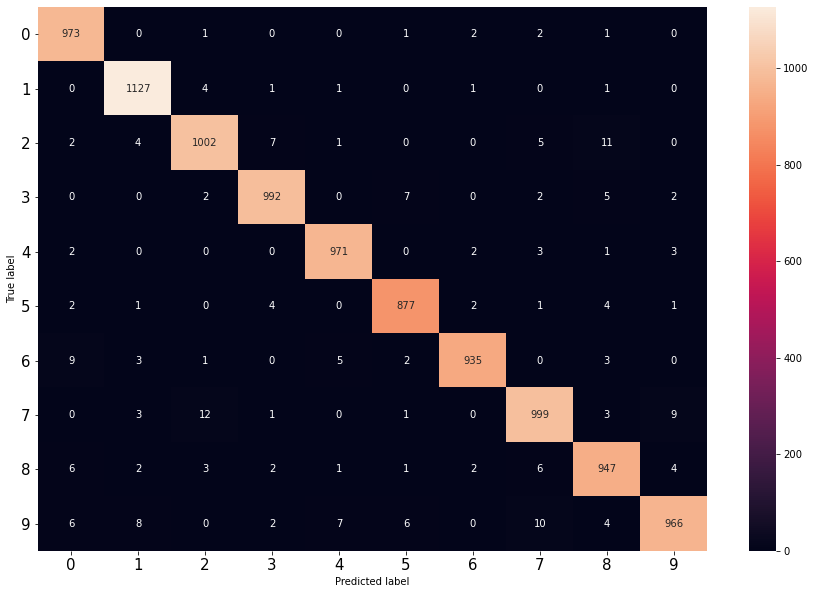

In [171]:
cf_matrix(model=mnist_net, test_loader=testDataLoader)

#### Question 7) What may be the potential problems when training the neural network with a large number of parameters?
- overfitting 가능성이 큼
- training time & computation cost가 큼

## Let's use Convolution Layer

### Convolution Operation

![Convolution](./imgs/Conv.png)



#### Question 8) Given input image with shape:(H, W, C1), what would be the shape of output image after applying 2 (F * F) convolutional filters with stride S?
- ((H-F)/S + 1, (W-F)/S + 1, 2)

### (9) 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [142]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [144]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [145]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [146]:
trainer.train(epoch = 4)

[1,   500] loss: 0.399
[1,  1000] loss: 0.170
[1,  1500] loss: 0.125
[2,   500] loss: 0.080
[2,  1000] loss: 0.082
[2,  1500] loss: 0.083
[3,   500] loss: 0.056
[3,  1000] loss: 0.062
[3,  1500] loss: 0.066
[4,   500] loss: 0.051
[4,  1000] loss: 0.052
[4,  1500] loss: 0.052
Finished Training


In [147]:
trainer.test()


Test set:  Accuracy: 9832/10000 (98%)



In [148]:
count_parameters(mnist_net)

11842

#### Question 9) How did the performance and the number of parameters change after using the Convolution operation? Why did these results come out?
- 성능은 좋아지고 parameter 수는 적어짐
- 이는 convloution operation이 2D image의 local 정보를 보존할 수 있기 때문 

### (10) 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

![Pooling](./imgs/Pool.png)



In [149]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [150]:
mnist_net = MNIST_Net()#.cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [151]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [152]:
trainer.train(epoch = 4)

[1,   500] loss: 0.545
[1,  1000] loss: 0.203
[1,  1500] loss: 0.155
[2,   500] loss: 0.118
[2,  1000] loss: 0.105
[2,  1500] loss: 0.097
[3,   500] loss: 0.085
[3,  1000] loss: 0.080
[3,  1500] loss: 0.080
[4,   500] loss: 0.069
[4,  1000] loss: 0.074
[4,  1500] loss: 0.072
Finished Training


In [153]:
trainer.test()


Test set:  Accuracy: 9789/10000 (98%)



In [154]:
count_parameters(mnist_net)

3202

#### Question 10) How did the performance change after using the Pooling operation? Why did these results come out?
- accuracy는 0.5% 정도 감소했지만 대신 parameter 수가 1/4로 줄어듦
- Pooling layer를 거치면 정보의 손실을 감수하는 대신 computational cost를 줄일 수 있음